<a href="https://colab.research.google.com/github/franklaercio/paul-the-octopus/blob/main/model/paultheoctopus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paul The Octopus Machine Learning

Code by Frank Laércio, Software Developer at CI&T.<br>
frank.junior@ciandt.com [github.com/franklaercio](https://github.com/franklaercio)

![banner.png](https://drive.google.com/uc?export=view&id=1euYvRBbkQtYMslUTwaUUdgcGFc_1gupL)

**Content**
1.   Importing libraries and files for GCP
2.   Fifa World Cup Data Analyzing
3.   Historical Results
4.   Ranking Fifa
5.   Modeling Machine Learning for Fifa World Cup Predictions
6.   Qatar World Cup Predictions



## **Importing libraries and files for GCP**

In this section we are import all libraries that need on this project.

*   Numpy for linear algebra
*   Pandas for manipuling data
*   Seaborn for data visualization
*   Matplotlib for data visualization



In [43]:
import numpy as np 
import pandas as pd
import re
import calendar
from datetime import datetime

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

project_id = 'phoenix-cit'
!gcloud config set project {project_id}

Updated property [core/project].


We are now starting to download files from Google Cloud Provider (GCP) and save to our Colab Notebook.

In [44]:
!gsutil -m cp gs://paul-the-octopus-frank-junior/*.csv /content

Copying gs://paul-the-octopus-frank-junior/historical_win-loose-draw_ratios.csv...
Copying gs://paul-the-octopus-frank-junior/historical-results.csv...
Copying gs://paul-the-octopus-frank-junior/matches-schedule.csv...
Copying gs://paul-the-octopus-frank-junior/sample_predictions_submission.csv...
Copying gs://paul-the-octopus-frank-junior/shootouts.csv...
Copying gs://paul-the-octopus-frank-junior/ranking.csv...
\ [6/6 files][  5.9 MiB/  5.9 MiB] 100% Done                                    
Operation completed over 6 objects/5.9 MiB.                                      


## **Fifa World Cup Data Analyzing**

In this section, we understand our dataset and make some assumptions. Like a does the FIFA ranking influence the results, are the clashes in world cups important in today's results or the win set is an interesting data.

First, we need to import the entire dataset for some assumptions.

### **Historical Results**

This section is an important part of building the algorithm, as we will check the previous results of the selections in matches. But we will make the following refinements to the data:
*   Check match dates.
*   Select the most played tournaments, as they are the most disputed.
*   Remove friendlies, as they can negatively influence predictions, due to their competitiveness.
*   Remove matches older than the 21st century, as soccer is very current.


In [45]:
# Importing the matchs
df_historical_results = pd.read_csv('/content/historical-results.csv')
df_historical_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [46]:
# Fixing the format date
for col in ['date']:
    df_historical_results[col] = pd.to_datetime(df_historical_results[col], format='%Y-%m-%d', errors='ignore')

# Parsing the date to datetime
df_historical_results['date'] = pd.to_datetime(df_historical_results['date'])

In [47]:
# Checking if exists null rows
df_historical_results.isnull().sum()

date          0
home_team     0
away_team     0
home_score    1
away_score    1
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [48]:
# Removing collumns not using in the model
df_historical_results = df_historical_results.drop (['neutral'], axis = 1)
df_historical_results = df_historical_results.drop (['city'], axis = 1)
df_historical_results = df_historical_results.drop (['country'], axis = 1)

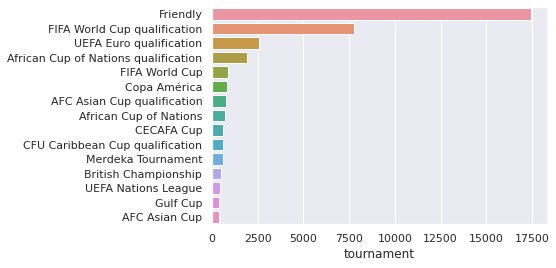

In [49]:
# Checking the 15 most tournaments
frequently_tournament = df_historical_results['tournament'].value_counts().nlargest(15)
sns.barplot(x=frequently_tournament, y=frequently_tournament.index)

In [50]:
# Removing the least played tournaments by teams. 
df_historical_results = df_historical_results[df_historical_results["tournament"].isin(frequently_tournament.index)]
df_historical_results.head()

,date,home_team,away_team,home_score,away_score,tournament
0,1872-11-30,Scotland,England,0.0,0.0,Friendly
1,1873-03-08,England,Scotland,4.0,2.0,Friendly
2,1874-03-07,Scotland,England,2.0,1.0,Friendly
3,1875-03-06,England,Scotland,2.0,2.0,Friendly
4,1876-03-04,Scotland,England,3.0,0.0,Friendly


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


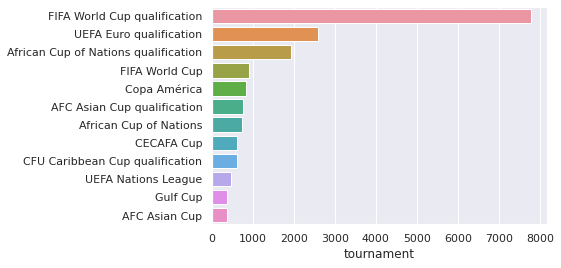

In [51]:
# Removing the follow tournaments: Friendly, British Championship and Merdeka Tournament
df_historical_results.drop(df_historical_results.index[(df_historical_results['tournament'] == 'Friendly')],axis=0,inplace=True)
df_historical_results.drop(df_historical_results.index[(df_historical_results['tournament'] == 'British Championship')],axis=0,inplace=True)
df_historical_results.drop(df_historical_results.index[(df_historical_results['tournament'] == 'Merdeka Tournament')],axis=0,inplace=True)

frequently_tournament = df_historical_results['tournament'].value_counts()
sns.barplot(x=frequently_tournament, y=frequently_tournament.index)

In [52]:
# Removing the matchs before 00s
df_historical_results = df_historical_results[~(df_historical_results['date'] <= '2000-01-01')]
df_historical_results.head()

,date,home_team,away_team,home_score,away_score,tournament
22796,2000-01-22,Ghana,Cameroon,1.0,1.0,African Cup of Nations
22797,2000-01-23,China PR,Philippines,8.0,0.0,AFC Asian Cup qualification
22798,2000-01-23,Egypt,Zambia,2.0,0.0,African Cup of Nations
22800,2000-01-23,Nigeria,Tunisia,4.0,2.0,African Cup of Nations
22801,2000-01-23,South Africa,Gabon,3.0,1.0,African Cup of Nations


In [53]:
# Checking the null values
df_historical_results.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
dtype: int64

In [54]:
# Changing the tournaments identifier
tornaments_names = {"FIFA World Cup qualification": 0, "UEFA Euro qualification": 1, "African Cup of Nations qualification": 2, "FIFA World Cup": 3, "Copa América": 4, "AFC Asian Cup qualification": 5, "African Cup of Nations": 6, "CECAFA Cup": 7, "CFU Caribbean Cup qualification": 8, "UEFA Nations League": 9, "Gulf Cup": 10, "AFC Asian Cup":11}

df_historical_results = df_historical_results.replace({"tournament": tornaments_names})

df_historical_results.head()

,date,home_team,away_team,home_score,away_score,tournament
22796,2000-01-22,Ghana,Cameroon,1.0,1.0,6
22797,2000-01-23,China PR,Philippines,8.0,0.0,5
22798,2000-01-23,Egypt,Zambia,2.0,0.0,6
22800,2000-01-23,Nigeria,Tunisia,4.0,2.0,6
22801,2000-01-23,South Africa,Gabon,3.0,1.0,6


Interesting, there is no null field in the dataset, so it will not be necessary to adjust the dataset to such values.

### **Ranking Fifa**

In this section we will check the Fifa ranking for each team. This step will be important for determining the algorithm, as the FIFA ranking makes a calculation to rank the strongest teams.

In [55]:
# Importing the ranking data to the notebook
df_ranking = pd.read_csv('/content/ranking.csv')
df_ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [56]:
# Removing collumns not using in the model
df_ranking = df_ranking.drop (['confederation'], axis = 1)
df_ranking = df_ranking.drop (['country_abrv'], axis = 1)
df_ranking = df_ranking.drop (['previous_points'], axis = 1)
df_ranking = df_ranking.drop (['rank_change'], axis = 1)

# Removing ranks before 00s
df_ranking = df_ranking[~(df_ranking['rank_date'] < '2000-01-01')]
df_ranking['rank_date'] = pd.to_datetime(df_ranking['rank_date'])

df_ranking.head()

,rank,country_full,total_points,rank_date
12119,136,Bahrain,223.0,2000-01-19
12120,135,Fiji,227.0,2000-01-19
12121,134,Madagascar,231.0,2000-01-19
12122,129,Eswatini,253.0,2000-01-19
12123,132,Sudan,244.0,2000-01-19


This part of the merge was inspired by the [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner).

In [57]:
# Setting index by rank_date
df_ranking = df_ranking.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# Merge the match data with ranking data
df_historical_results = df_historical_results.merge(df_ranking, left_on=['date', 'home_team'], right_on=['rank_date', 'country_full'])
df_historical_results = df_historical_results.merge(df_ranking, left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=('_home', '_away'))

In [58]:
# Deliting some collums that we don't need
df_historical_results = df_historical_results.drop (['country_full_home'], axis = 1)
df_historical_results = df_historical_results.drop (['country_full_away'], axis = 1)
df_historical_results = df_historical_results.drop (['total_points_away'], axis = 1)
df_historical_results = df_historical_results.drop (['total_points_home'], axis = 1)
df_historical_results = df_historical_results.drop (['rank_date_away'], axis = 1)
df_historical_results = df_historical_results.drop (['rank_date_home'], axis = 1)
df_historical_results = df_historical_results.drop (['date'], axis = 1)

In [59]:
# Checking the data frame of machs
df_historical_results.head()

,home_team,away_team,home_score,away_score,tournament,rank_home,rank_away
0,Ghana,Cameroon,1.0,1.0,6,50.0,57.0
1,China PR,Philippines,8.0,0.0,5,88.0,181.0
2,Egypt,Zambia,2.0,0.0,6,38.0,36.0
3,Nigeria,Tunisia,4.0,2.0,6,76.0,28.0
4,South Africa,Gabon,3.0,1.0,6,31.0,72.0


In [60]:
# Calculing the rank_difference, average_rank, score_difference nad is_won
df_historical_results['rank_difference'] = df_historical_results['rank_home'] - df_historical_results['rank_away']
df_historical_results['average_rank'] = (df_historical_results['rank_home'] + df_historical_results['rank_away'])/2
df_historical_results['score_difference'] = df_historical_results['home_score'] - df_historical_results['away_score']
df_historical_results['is_won'] = df_historical_results['score_difference'] > 0

In [61]:
# Checking the data frame of machs
df_historical_results.head()

,home_team,away_team,home_score,away_score,tournament,rank_home,rank_away,rank_difference,average_rank,score_difference,is_won
0,Ghana,Cameroon,1.0,1.0,6,50.0,57.0,-7.0,53.5,0.0,False
1,China PR,Philippines,8.0,0.0,5,88.0,181.0,-93.0,134.5,8.0,True
2,Egypt,Zambia,2.0,0.0,6,38.0,36.0,2.0,37.0,2.0,True
3,Nigeria,Tunisia,4.0,2.0,6,76.0,28.0,48.0,52.0,2.0,True
4,South Africa,Gabon,3.0,1.0,6,31.0,72.0,-41.0,51.5,2.0,True


## **Modeling Machine Learning for Fifa World Cup Predictions**

In this section we will make the predictions after organizing the data previously done. For this, we will use the decision tree technique and a regression forest. These are algorithms provided by the sklearn library. <br>
Para fazer o aprendizado iremos utilizar os dados da diferença de ranks e a média do rank. In addition, to verify the effectiveness of the algorithm, we will use the data of who won or lost the match.


In [62]:
# Predict target
X, y, X_test = df_historical_results.loc[:,['average_rank', 'rank_difference']], df_historical_results['is_won'], df_historical_results.loc[:,['average_rank', 'rank_difference']]

# Importing all the libraries we need
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classification Algorithm
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X, y)

# Make a prediction
Y_prediction = random_forest.predict(X_test)

# Checking accuracy
random_forest.score(X, y)
acc_random_forest = round(random_forest.score(X, y) * 100, 2)

print("Accuracy Random Forest: ", acc_random_forest)

Accuracy Random Forest:  94.25


## **Qatar World Cup Predictions**
In this section we will read data from group stage matches and make predictions on the results.

In [63]:
# Importing the data to local notebook
df_qatar_world_cup = pd.read_csv('/content/matches-schedule.csv')
df_qatar_world_cup.head()

,match,date,country1,country2,phase
0,1,21/11/2022,Qatar,Ecuador,group matches
1,2,21/11/2022,Senegal,Netherlands,group matches
2,3,21/11/2022,England,Iran,group matches
3,4,21/11/2022,USA,Wales,group matches
4,5,22/11/2022,France,Australia,group matches


In [64]:
# Removing pashe and date of qatar_world_cup
df_qatar_world_cup = df_qatar_world_cup.drop (['phase'], axis = 1)
df_qatar_world_cup = df_qatar_world_cup.drop (['date'], axis = 1)

In [65]:
# Adjusting the name of the teams of Korea and Iran.
df_ranking = df_ranking.replace('Korea Republic', 'South Korea')
df_ranking = df_ranking.replace('IR Iran', 'Iran')

In [66]:
# Retrieving the latest FIFA ranking result for each football selection.
world_cup_rankings = df_ranking.loc[(df_ranking['rank_date'] == df_ranking['rank_date'].max()) & 
                                    df_ranking['country_full'].isin(df_qatar_world_cup['country1'].unique())]

Important points for predicting the results are:
*   Modeling uses the difference in rank to establish the winner.
*   The probability of the away team winning is the inverse of the home team.
*   O placar é iniciado em 0 a 0 "como se fosse um início de partida".
*   If the team's probability is between 60% and 70%, the team "scores a goal".
*   If the probability of the team winning is greater than 70%, the team "scores 2 goals".



In [69]:
predictions = pd.DataFrame(columns={"home", "home_score", "away_score", "away"})

for match, home, away in df_qatar_world_cup.values:
  row = pd.DataFrame(np.array([[np.nan, np.nan]]), columns=X_test.columns)

  home_rank = world_cup_rankings[world_cup_rankings["country_full"] == home]['rank'].values
  away_rank = world_cup_rankings[world_cup_rankings["country_full"] == away]['rank'].values

  row['average_rank'] = (home_rank + away_rank) / 2
  row['rank_difference'] = home_rank - away_rank
  
  home_win_prob = random_forest.predict_proba(row)[:,1][0]
  away_win_prob = 1 - home_win_prob

  home_score = 0
  away_score = 0

  if home_win_prob > 0.60 and home_win_prob < 0.70:
    home_score = 1
  elif home_win_prob > 0.70:
    home_score = 2
  else: 
    if away_win_prob > 0.60 and away_win_prob < 0.70:
      away_score = 1
    else:
      away_score = 2      
  
  predictions = predictions.append({"home": home, "home_score": home_score, "away_score": away_score, "away": away}, ignore_index=True)

Finally, the result is first stored locally and then sent to GCP.

In [70]:
predictions.to_csv('predictions_submission.csv', index=False)

!gsutil -m cp /content/predictions_submission.csv gs://paul-the-octopus-frank-junior/

Copying file:///content/predictions_submission.csv [Content-Type=text/csv]...
/ [1/1 files][   1001 B/   1001 B] 100% Done                                    
Operation completed over 1 objects/1001.0 B.                                     
